# Preparation of Milestone 2

Today we will start to prepare the second milestone. The goals of this milestone are

- Implement an image classification pipeline
    - Implement a Pytorch classification dataset
    - Implement at least two custom augmentations (do not just import one from Torchvision or albumentations)
    - Implement a training and validation loop
    - Optimize your model
    - Evaluate the performance of your model with the F1 score on the test set

### AgNOR-scoring pipeline

To determine the AgNOR-score, we consider the problem an object detection task, where nuclei are discriminated based on the number of identifiable AgNORs. For detection, we used the fully convolutional one-stage object detector (FCOS) by Tian et al. [10], which is a state-of-the-art object detector that does not use anchor boxes like previous approaches and thus comes with a reduced set of hyperparameters to tune. To account for imbalances in the training data, we ensembled five detection models which were trained on five random subsets of the training data. Each of the five models produced its own AgNOR-score by averaging the class labels of all nuclei detected in one image. We used the median to aggregate the results of the ensemble of models per image. During training, we oversampled classes with lower support because of the class imbalance present in the training data. For the same reason, we used a small patch size of 128 × 128 pixels for training since this gave us better control over the classes present on each patch. All models were trained until convergence as observed by the validation loss with a learning rate of 10−4 and Adam as optimizer. To ensure comparability between the results of the study and those of the algorithm, the inference of the detectors was performed analogously to the annotation of the experts described before. The respective image was divided into the same 12 fields, which needed to be processed in the same order as in the study until at least 100 nuclei were detected and classified.

# Pytorch Classification Dataset 

To train neural networks in pytorch with custom datasets, custom dataset classes are needed. Today we will work on a dataset for the term project. A general introduction to custom datasets can be found [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).



Your dataset must have several properties that are specific to the task:

1. Since you only have a small number of images, you will need to use image augmentation. Image augmentation is always applied on the fly. **Never apply image augmentation to images and save the augmented versions to disk for sampling!** Normally, you can use the image augmentation implemented in albumentations or torchvision. **For this project, you will need to implement two augmentations yourself**. I would suggest implementing an augmentation that applies a Gaussian blur to the image and a function that applies a color jitter to the image. Implement the augmentations in a way that they can be **composed** with other TorchVision transformations.

2. Apply minority class oversampling and majority class undersampling for better generalization. You can either implement an initialization function in your dataset where you first sample the coordinates for this epoch, or sample the coordinates on the fly in the __getitem__ method.

3. Your dataset class will inherit from torch.utils.data.Dataset. But you must override the **__len__** and **__getitem__** functions.

## Imports 

In [1]:
import torch
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image 
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms, Resize
from torchvision.models import efficientnet_b0
from tqdm import tqdm
from torchmetrics import Accuracy
import torch.nn as nn
# from torcheval.metrics.functional import multiclass_f1_score

# Pytorch Classification Dataset Class

In [2]:
class AgNORDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # returns the number of samples in our dataset.
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = ToTensor()(Image.open(img_path))
        image = Image.open(img_path).convert("RGB")
        filename, max_x, max_y, min_x, min_y, label = self.img_labels.iloc[idx]
        image = image.crop((min_x,min_y,max_x,max_y))
        # cropped_image = image[min_x:min_y, max_x:max_y]

        # Gaussian blur
        # color jitter
        

        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

## Image Augmentation Class

In [3]:
class GaussianBlur(object):
    def __init__(self, radius=1):
        self.radius = radius

    def __call__(self, img):
        if random.random() < 0.5:
            return img
        else:
            return img.filter(ImageFilter.GaussianBlur(radius=self.radius))

class ColorJitter(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def __call__(self, img):
        transforms = []
        if self.brightness > 0:
            brightness_factor = random.uniform(max(0, 1 - self.brightness), 1 + self.brightness)
            transforms.append(torchvision.transforms.Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

        if self.contrast > 0:
            contrast_factor = random.uniform(max(0, 1 - self.contrast), 1 + self.contrast)
            transforms.append(torchvision.transforms.Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

        if self.saturation > 0:
            saturation_factor = random.uniform(max(0, 1 - self.saturation), 1 + self.saturation)
            transforms.append(torchvision.transforms.Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

        if self.hue > 0:
            hue_factor = random.uniform(-self.hue, self.hue)
            transforms.append(torchvision.transforms.Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        random.shuffle(transforms)
        transform = torchvision.transforms.Compose(transforms)
        return transform(img)

# Loading our Dataset

In [4]:
transform = transforms.Compose([
    Resize((224, 224)),  # the pretrained model will expect images to be all fixed size
    ToTensor()
])            
dataset = AgNORDataset(annotations_file='annotation_frame.csv',
                       img_dir='Dataset',
                       transform=transform,
                       target_transform=None)

# dataset.__getitem__(0)

# Iterating and Visualizing a sample of the Dataset

you have to set the <span style="font-size: bigger;">**transfrom=False**</span> for the visualization purpouses beacause of the size of the transforation

In [5]:
# labels_map = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]
# dataset.transform = False

# figure = plt.figure(figsize=(10, 10))
# cols, rows = 12, 12
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(dataset.__len__(), size=(1,)).item()
#     img, label = dataset.__getitem__(sample_idx)
#     figure.add_subplot(rows, cols, i)
#     plt.title(labels_map[label])
#     plt.axis('off')
#     plt.imshow(img)
    
# plt.show()

In [6]:
dataset.transform = transform

# Training/Validation/Test Split

After you have successfully created your dataset, you need to define a training, validation, and test split of the data. Split the images at the image level! Splits must not overlap!

1. Split the data.
2. Initialize a dataset for each split and pass it to a Pytorch dataloader.

In [7]:
train_size = int(0.7 * dataset.__len__())
eval_size = int(0.15 * dataset.__len__())
test_size = dataset.__len__() - train_size - eval_size

train_dataset, eval_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=32)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

# Initliazie a classification model from pytorch.

For classification we will use a pre-trained model from pytorch. I would suggest an efficientnet_b0. Since we do not have too much training data and to mitigate overfitting, we will use ImageNet weights and only train the last layer. We will also freeze most of the network since we do not have much data and to save training time.

1. Load the model from torchvision (see[https://pytorch.org/vision/stable/models.html]).
2. Load the respective weights.
3. Freeze all but the last layer. If you have a gpu available, bring your model to the gpu.

In [8]:
weights = 'IMAGENET1K_V1' 
model = efficientnet_b0(weights=weights)
model.classifier[1] = nn.Linear(1280,12)

# print(f'{name} --> {param.requires_grad}')
# model.features.requires_grad == False
# model.features.children
for name, param in model.named_parameters():
    param.requires_grad = False
    # print(name, param.requires_grad)
for name, param in model.classifier.named_parameters():
    param.requires_grad = True
    # print(name, param.requires_grad)
# model.classifier

In [9]:
# # from torchvision.models import ResNet50_Weights
# import torchvision

# # weights = ResNet50_Weights.DEFAULT
# model = torchvision.models.resnet50(weights='DEFAULT')

# # model.eval()


# # Freeze all but the last layer
# for name, param in model.named_parameters():
#     param.requires_grad = False
#     # print(name, param.requires_grad)
# # Set requires_grad=True only for the parameters of the last layer
# for name, param in model.fc.named_parameters():
#     param.requires_grad = True
#     # print(name, param.requires_grad)


<span style="font-size: 16px;">print the last layer which will be used for backprop</span>

In [10]:
# from torchviz import make_dot
# dummy_input = torch.randn(32, 3, 3, 3)
# output = model(dummy_input)
# make_dot(output, params=dict(model.named_parameters()),show_attrs=True)

# Optimization Loop

a) The next step is the actual model optimization. But before we implement the training and validation loops, we need to initialize a loss function and an optimizer. We can use Adam as the optimizer and Cross Entropy Loss as the loss function from pytorch. We also need to set a learning rate for the model optimization.

1. Initialize a Loss Function
2. Initializing an Optimizer and Setting a Learning Rate


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
num_classes = 12
task = 'MULTICLASS'
device = torch.device("mps")
model.to(device)
metric=Accuracy(task=task,num_classes=num_classes).to(device)

b) Now, we will implement an optimization loop. First we implement the training phase. Implement a function (**train_one_epoch**) which performs the follwing steps.:

1. Define a variable running_loss in which you can store the change in loss during training. Since we will later chain the function with a validation function, bring the model to training mode if needed.
2. Iterate over your train dataloader, in each epoch you must:
    1. Transfer the tensors with the images and labels to the GPU or CPU, depending on the device on which your model is located.
    2. Delete the old gradients in the optimizer.
    3. Perform the actual forward pass, i.e. pass the images to the model and calculate the predictions (model(imgs))
    4. Calculate the loss
    5. Backpropagate the loss (loss.backward())
    6. Perform the optimization step (optimizer.stepp())
    7. Add the loss of the current batch to your running_loss
    8. Print the loss every x batches, also return the average loss of the epoch

**Tip:** use **[tqdm.notebook.tqdm](https://tqdm.github.io/docs/notebook/)** to visualize the progress during the epoch.

In [12]:
def train_one_epoch(model, train_loader, loss_fn, device):
    model = model.to(device)
    model.train()
    
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Training iteration")):
        running_loss = 0.0
        images, labels = images.to(device), labels.to(device)
        # model.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if batch_idx % 10 == 9: #  Print the loss every 10 batches
            avg_loss = running_loss / 10
            #print(f'Batch {batch_idx + 1}/{len(train_loader)}, Loss: {avg_loss:.4f}')
        
        avg_loss = running_loss / len(train_loader)
            
    
    return avg_loss

In [ ]:
train_one_epoch(
    model=model,
    train_loader=train_loader,
    loss_fn=loss_fn,
    device=device
)

Training iteration:  66%|█████████████▊       | 283/432 [02:44<01:26,  1.73it/s]

c) We also need a validation loop, which is called after a training loop to determine the training progress on the validation data. Implement this in a function (**validate_one_epoch**). This loop looks very similar to the training loop, but we can skip the backpropagation here. Also, use a metric from Torchmetrics to measure the performance of your models. The validation function should also return the loss or the metric so you can use it to select the best model during training.

1. Turn off gradient storage. Put your model in evaluation mode. Since there is no backpropagation in the validation, we do not need it and can save a lot of memory.
2. As with the training loop, iterate over the validation data loader and perform a forward pass in each epoch.
3. Compute a loss in each epoch, but not backpropagated
4. Store and output the loss and return the average loss of the epoch
5. Update your metric with the predictions and labels of each batch
6. Calculate your metric after the last batch.


In [20]:
def validate_one_epoch(model, eval_loader, loss_fn, metric, device):
    model = model.to(device)
    model.eval()
    metric.reset()
    
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(eval_loader, desc="Validation iteration"):
            images, labels = images.to(device), labels.to(device)
    

            outputs = model(images)
    
            loss = loss_fn(outputs, labels)
    
            running_loss += loss.item()

            metric(outputs, labels)

    
    
            avg_loss = running_loss / len(eval_loader)

            metric_result = metric.compute()
    
    return avg_loss, metric_result

In [21]:
validate_one_epoch(
    model=model,
    eval_loader=eval_loader,
    loss_fn=loss_fn,
    metric=metric,
    device=device
)

Validation iteration: 100%|█████████████████████| 93/93 [00:48<00:00,  1.92it/s]


(1.0841234736545111, tensor(0.5875, device='mps:0'))

d) Combine training and validation in an optimization loop. This loop is run **n_epochs** times. In each iteration, first call your training function and then your validation function. In each epoch, check to see if your model has improved, and if so, save the model. Do not save a new checkpoint in each epoch, as this will consume too much memory. Save the losses of the training and validation functions over the epochs to plot them at the end of your training. If you do not have a GPU available, you do not need to train your model to convergence. Just train a few steps.

In [16]:
def optimization_loop(model, train_loader, val_loader, loss_fn, optimizer, metric, device, n_epochs, model_save_path=None):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    # device=('cpu')
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")

        # Training 
        train_loss = train_one_epoch(model, train_loader, loss_fn, device)
        train_losses.append(train_loss)
        print(f"Train Loss: {train_loss:.4f}")

        # Validation 
        val_loss, metric_result = validate_one_epoch(model, eval_loader, loss_fn, metric, device)
        val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
        
            if model_save_path:
                torch.save(model.state_dict(), model_save_path)
                print("Model saved.")

    plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

In [17]:
model_save_path = 'best_model.pth'
n_epochs=1

Epoch 1/10


Training iteration:   2%|▌                     | 10/432 [00:08<04:36,  1.53it/s]

Batch 10/432, Loss: 1.9453


Training iteration:   5%|█                     | 20/432 [00:14<04:21,  1.57it/s]

Batch 20/432, Loss: 1.5117


Training iteration:   7%|█▌                    | 30/432 [00:20<04:16,  1.57it/s]

Batch 30/432, Loss: 1.5182


Training iteration:   9%|██                    | 40/432 [00:27<04:33,  1.44it/s]

Batch 40/432, Loss: 1.4008


Training iteration:  12%|██▌                   | 50/432 [00:33<04:10,  1.53it/s]

Batch 50/432, Loss: 1.4012


Training iteration:  14%|███                   | 60/432 [00:40<03:57,  1.57it/s]

Batch 60/432, Loss: 1.4417


Training iteration:  16%|███▌                  | 70/432 [00:46<03:36,  1.67it/s]

Batch 70/432, Loss: 1.3644


Training iteration:  19%|████                  | 80/432 [00:52<03:29,  1.68it/s]

Batch 80/432, Loss: 1.4167


Training iteration:  21%|████▌                 | 90/432 [00:59<03:43,  1.53it/s]

Batch 90/432, Loss: 1.3633


Training iteration:  23%|████▊                | 100/432 [01:05<03:43,  1.49it/s]

Batch 100/432, Loss: 1.3550


Training iteration:  25%|█████▎               | 110/432 [01:11<03:08,  1.71it/s]

Batch 110/432, Loss: 1.2879


Training iteration:  28%|█████▊               | 120/432 [01:17<03:09,  1.65it/s]

Batch 120/432, Loss: 1.3324


Training iteration:  30%|██████▎              | 130/432 [01:23<02:54,  1.73it/s]

Batch 130/432, Loss: 1.3431


Training iteration:  32%|██████▊              | 140/432 [01:30<03:08,  1.55it/s]

Batch 140/432, Loss: 1.3268


Training iteration:  35%|███████▎             | 150/432 [01:37<03:34,  1.32it/s]

Batch 150/432, Loss: 1.2941


Training iteration:  37%|███████▊             | 160/432 [01:44<02:55,  1.55it/s]

Batch 160/432, Loss: 1.2188


Training iteration:  39%|████████▎            | 170/432 [01:50<02:43,  1.61it/s]

Batch 170/432, Loss: 1.2058


Training iteration:  42%|████████▊            | 180/432 [01:56<02:38,  1.59it/s]

Batch 180/432, Loss: 1.2658


Training iteration:  44%|█████████▏           | 190/432 [02:02<02:30,  1.61it/s]

Batch 190/432, Loss: 1.2518


Training iteration:  46%|█████████▋           | 200/432 [02:09<02:26,  1.59it/s]

Batch 200/432, Loss: 1.3148


Training iteration:  49%|██████████▏          | 210/432 [02:14<01:53,  1.96it/s]

Batch 210/432, Loss: 1.2641


Training iteration:  51%|██████████▋          | 220/432 [02:20<02:04,  1.70it/s]

Batch 220/432, Loss: 1.2038


Training iteration:  53%|███████████▏         | 230/432 [02:26<01:56,  1.74it/s]

Batch 230/432, Loss: 1.2321


Training iteration:  56%|███████████▋         | 240/432 [02:32<02:04,  1.55it/s]

Batch 240/432, Loss: 1.2746


Training iteration:  58%|████████████▏        | 250/432 [02:39<01:52,  1.62it/s]

Batch 250/432, Loss: 1.2697


Training iteration:  60%|████████████▋        | 260/432 [02:46<02:13,  1.29it/s]

Batch 260/432, Loss: 1.3418


Training iteration:  62%|█████████████▏       | 270/432 [02:53<01:41,  1.59it/s]

Batch 270/432, Loss: 1.2265


Training iteration:  65%|█████████████▌       | 280/432 [02:58<01:20,  1.90it/s]

Batch 280/432, Loss: 1.2449


Training iteration:  67%|██████████████       | 290/432 [03:04<01:17,  1.84it/s]

Batch 290/432, Loss: 1.1739


Training iteration:  69%|██████████████▌      | 300/432 [03:09<01:06,  1.99it/s]

Batch 300/432, Loss: 1.2125


Training iteration:  72%|███████████████      | 310/432 [03:14<01:04,  1.90it/s]

Batch 310/432, Loss: 1.3318


Training iteration:  74%|███████████████▌     | 320/432 [03:20<01:10,  1.59it/s]

Batch 320/432, Loss: 1.2424


Training iteration:  76%|████████████████     | 330/432 [03:25<00:54,  1.88it/s]

Batch 330/432, Loss: 1.2161


Training iteration:  79%|████████████████▌    | 340/432 [03:32<00:53,  1.72it/s]

Batch 340/432, Loss: 1.2386


Training iteration:  81%|█████████████████    | 350/432 [03:37<00:41,  1.97it/s]

Batch 350/432, Loss: 1.2234


Training iteration:  83%|█████████████████▌   | 360/432 [03:42<00:35,  2.01it/s]

Batch 360/432, Loss: 1.2040


Training iteration:  86%|█████████████████▉   | 370/432 [03:47<00:32,  1.89it/s]

Batch 370/432, Loss: 1.2166


Training iteration:  88%|██████████████████▍  | 380/432 [03:52<00:26,  1.98it/s]

Batch 380/432, Loss: 1.2320


Training iteration:  90%|██████████████████▉  | 390/432 [03:58<00:21,  1.93it/s]

Batch 390/432, Loss: 1.2414


Training iteration:  93%|███████████████████▍ | 400/432 [04:03<00:16,  1.97it/s]

Batch 400/432, Loss: 1.2945


Training iteration:  95%|███████████████████▉ | 410/432 [04:08<00:11,  1.96it/s]

Batch 410/432, Loss: 1.2313


Training iteration:  97%|████████████████████▍| 420/432 [04:13<00:06,  1.83it/s]

Batch 420/432, Loss: 1.2849


Training iteration: 100%|████████████████████▉| 430/432 [04:19<00:01,  1.78it/s]

Batch 430/432, Loss: 1.1594


Training iteration: 100%|█████████████████████| 432/432 [04:21<00:00,  1.65it/s]


Train Loss: 0.0064


Validation iteration: 100%|█████████████████████| 93/93 [00:46<00:00,  1.98it/s]


Validation Loss: 1.1647
Model saved.
Epoch 2/10


Training iteration:   2%|▌                     | 10/432 [00:05<03:42,  1.90it/s]

Batch 10/432, Loss: 1.0558


Training iteration:   5%|█                     | 20/432 [00:10<03:27,  1.99it/s]

Batch 20/432, Loss: 1.2148


Training iteration:   7%|█▌                    | 30/432 [00:15<03:18,  2.03it/s]

Batch 30/432, Loss: 1.1473


Training iteration:   9%|██                    | 40/432 [00:20<03:14,  2.01it/s]

Batch 40/432, Loss: 1.0764


Training iteration:  12%|██▌                   | 50/432 [00:26<03:25,  1.85it/s]

Batch 50/432, Loss: 1.2330


Training iteration:  14%|███                   | 60/432 [00:31<03:05,  2.00it/s]

Batch 60/432, Loss: 1.2094


Training iteration:  16%|███▌                  | 70/432 [00:36<03:25,  1.76it/s]

Batch 70/432, Loss: 1.2596


Training iteration:  19%|████                  | 80/432 [00:41<02:57,  1.98it/s]

Batch 80/432, Loss: 1.1729


Training iteration:  21%|████▌                 | 90/432 [00:46<02:58,  1.91it/s]

Batch 90/432, Loss: 1.2132


Training iteration:  23%|████▊                | 100/432 [00:51<02:48,  1.97it/s]

Batch 100/432, Loss: 1.2408


Training iteration:  25%|█████▎               | 110/432 [00:56<02:47,  1.92it/s]

Batch 110/432, Loss: 1.1601


Training iteration:  28%|█████▊               | 120/432 [01:01<02:35,  2.01it/s]

Batch 120/432, Loss: 1.1512


Training iteration:  30%|██████▎              | 130/432 [01:06<02:34,  1.95it/s]

Batch 130/432, Loss: 1.1460


Training iteration:  32%|██████▊              | 140/432 [01:11<02:26,  2.00it/s]

Batch 140/432, Loss: 1.1054


Training iteration:  35%|███████▎             | 150/432 [01:16<02:24,  1.95it/s]

Batch 150/432, Loss: 1.1339


Training iteration:  37%|███████▊             | 160/432 [01:21<02:24,  1.88it/s]

Batch 160/432, Loss: 1.1478


Training iteration:  39%|████████▎            | 170/432 [01:26<02:14,  1.95it/s]

Batch 170/432, Loss: 1.2859


Training iteration:  42%|████████▊            | 180/432 [01:31<02:06,  2.00it/s]

Batch 180/432, Loss: 1.1032


Training iteration:  44%|█████████▏           | 190/432 [01:36<02:04,  1.94it/s]

Batch 190/432, Loss: 1.2230


Training iteration:  46%|█████████▋           | 200/432 [01:41<01:56,  2.00it/s]

Batch 200/432, Loss: 1.1682


Training iteration:  49%|██████████▏          | 210/432 [01:46<01:49,  2.03it/s]

Batch 210/432, Loss: 1.1593


Training iteration:  51%|██████████▋          | 220/432 [01:51<01:49,  1.94it/s]

Batch 220/432, Loss: 1.2191


Training iteration:  53%|███████████▏         | 230/432 [01:57<02:00,  1.68it/s]

Batch 230/432, Loss: 1.2193


Training iteration:  56%|███████████▋         | 240/432 [02:02<01:38,  1.95it/s]

Batch 240/432, Loss: 1.1727


Training iteration:  58%|████████████▏        | 250/432 [02:07<01:33,  1.95it/s]

Batch 250/432, Loss: 1.2083


Training iteration:  60%|████████████▋        | 260/432 [02:12<01:26,  1.99it/s]

Batch 260/432, Loss: 1.2025


Training iteration:  62%|█████████████▏       | 270/432 [02:17<01:22,  1.97it/s]

Batch 270/432, Loss: 1.1580


Training iteration:  65%|█████████████▌       | 280/432 [02:22<01:17,  1.95it/s]

Batch 280/432, Loss: 1.1721


Training iteration:  67%|██████████████       | 290/432 [02:28<01:20,  1.77it/s]

Batch 290/432, Loss: 1.1104


Training iteration:  69%|██████████████▌      | 300/432 [02:33<01:06,  1.97it/s]

Batch 300/432, Loss: 1.2085


Training iteration:  72%|███████████████      | 310/432 [02:39<01:08,  1.77it/s]

Batch 310/432, Loss: 1.1806


Training iteration:  74%|███████████████▌     | 320/432 [02:44<00:56,  1.99it/s]

Batch 320/432, Loss: 1.1004


Training iteration:  76%|████████████████     | 330/432 [02:49<00:51,  1.98it/s]

Batch 330/432, Loss: 1.1678


Training iteration:  79%|████████████████▌    | 340/432 [02:54<00:46,  1.97it/s]

Batch 340/432, Loss: 1.1565


Training iteration:  81%|█████████████████    | 350/432 [02:59<00:41,  1.98it/s]

Batch 350/432, Loss: 1.2198


Training iteration:  83%|█████████████████▌   | 360/432 [03:04<00:36,  1.99it/s]

Batch 360/432, Loss: 1.1766


Training iteration:  86%|█████████████████▉   | 370/432 [03:09<00:31,  1.96it/s]

Batch 370/432, Loss: 1.1691


Training iteration:  88%|██████████████████▍  | 380/432 [03:14<00:25,  2.01it/s]

Batch 380/432, Loss: 1.2520


Training iteration:  90%|██████████████████▉  | 390/432 [03:19<00:21,  1.97it/s]

Batch 390/432, Loss: 1.1725


Training iteration:  93%|███████████████████▍ | 400/432 [03:24<00:15,  2.02it/s]

Batch 400/432, Loss: 1.2317


Training iteration:  95%|███████████████████▉ | 410/432 [03:29<00:11,  1.96it/s]

Batch 410/432, Loss: 1.1983


Training iteration:  97%|████████████████████▍| 420/432 [03:34<00:06,  1.98it/s]

Batch 420/432, Loss: 1.1809


Training iteration: 100%|████████████████████▉| 430/432 [03:40<00:01,  1.92it/s]

Batch 430/432, Loss: 1.1307


Training iteration: 100%|█████████████████████| 432/432 [03:41<00:00,  1.95it/s]


Train Loss: 0.0056


Validation iteration: 100%|█████████████████████| 93/93 [00:44<00:00,  2.07it/s]


Validation Loss: 1.1189
Model saved.
Epoch 3/10


Training iteration:   2%|▌                     | 10/432 [00:05<03:46,  1.86it/s]

Batch 10/432, Loss: 1.0794


Training iteration:   5%|█                     | 20/432 [00:10<03:32,  1.93it/s]

Batch 20/432, Loss: 1.1683


Training iteration:   7%|█▌                    | 30/432 [00:15<03:29,  1.92it/s]

Batch 30/432, Loss: 1.1713


Training iteration:   9%|██                    | 40/432 [00:21<03:19,  1.97it/s]

Batch 40/432, Loss: 1.1393


Training iteration:  12%|██▌                   | 50/432 [00:26<03:13,  1.97it/s]

Batch 50/432, Loss: 1.0487


Training iteration:  14%|███                   | 60/432 [00:31<03:06,  2.00it/s]

Batch 60/432, Loss: 1.1508


Training iteration:  16%|███▌                  | 70/432 [00:36<03:02,  1.99it/s]

Batch 70/432, Loss: 1.0944


Training iteration:  19%|████                  | 80/432 [00:41<03:00,  1.95it/s]

Batch 80/432, Loss: 1.2144


Training iteration:  21%|████▌                 | 90/432 [00:46<02:51,  1.99it/s]

Batch 90/432, Loss: 1.2094


Training iteration:  23%|████▊                | 100/432 [00:51<02:47,  1.98it/s]

Batch 100/432, Loss: 1.1514


Training iteration:  25%|█████▎               | 110/432 [00:56<02:40,  2.00it/s]

Batch 110/432, Loss: 1.1116


Training iteration:  28%|█████▊               | 120/432 [01:01<02:42,  1.92it/s]

Batch 120/432, Loss: 1.0873


Training iteration:  30%|██████▎              | 130/432 [01:08<03:41,  1.36it/s]

Batch 130/432, Loss: 1.1347


Training iteration:  32%|██████▊              | 140/432 [01:15<02:54,  1.68it/s]

Batch 140/432, Loss: 1.0438


Training iteration:  35%|███████▎             | 150/432 [01:21<02:38,  1.78it/s]

Batch 150/432, Loss: 1.1205


Training iteration:  37%|███████▊             | 160/432 [01:27<02:34,  1.76it/s]

Batch 160/432, Loss: 1.1001


Training iteration:  39%|████████▎            | 170/432 [01:32<02:17,  1.90it/s]

Batch 170/432, Loss: 1.2051


Training iteration:  42%|████████▊            | 180/432 [01:37<02:10,  1.93it/s]

Batch 180/432, Loss: 1.1466


Training iteration:  44%|█████████▏           | 190/432 [01:42<02:04,  1.94it/s]

Batch 190/432, Loss: 1.1775


Training iteration:  46%|█████████▋           | 200/432 [01:47<01:57,  1.97it/s]

Batch 200/432, Loss: 1.0930


Training iteration:  49%|██████████▏          | 210/432 [01:52<01:53,  1.95it/s]

Batch 210/432, Loss: 1.2181


Training iteration:  51%|██████████▋          | 220/432 [01:58<02:01,  1.74it/s]

Batch 220/432, Loss: 1.2472


Training iteration:  53%|███████████▏         | 230/432 [02:03<01:44,  1.93it/s]

Batch 230/432, Loss: 1.0891


Training iteration:  56%|███████████▋         | 240/432 [02:08<01:38,  1.95it/s]

Batch 240/432, Loss: 1.1667


Training iteration:  58%|████████████▏        | 250/432 [02:14<01:34,  1.92it/s]

Batch 250/432, Loss: 1.0735


Training iteration:  60%|████████████▋        | 260/432 [02:19<01:34,  1.82it/s]

Batch 260/432, Loss: 1.2203


Training iteration:  62%|█████████████▏       | 270/432 [02:24<01:25,  1.89it/s]

Batch 270/432, Loss: 1.1113


Training iteration:  65%|█████████████▌       | 280/432 [02:31<02:14,  1.13it/s]

Batch 280/432, Loss: 1.1766


Training iteration:  67%|██████████████       | 290/432 [02:43<02:40,  1.13s/it]

Batch 290/432, Loss: 1.0888


Training iteration:  69%|██████████████▌      | 300/432 [02:51<01:57,  1.13it/s]

Batch 300/432, Loss: 1.3207


Training iteration:  72%|███████████████      | 310/432 [03:02<02:11,  1.08s/it]

Batch 310/432, Loss: 1.1552


Training iteration:  74%|███████████████▌     | 320/432 [03:10<01:54,  1.02s/it]

Batch 320/432, Loss: 1.1831


Training iteration:  76%|████████████████     | 330/432 [03:16<00:57,  1.79it/s]

Batch 330/432, Loss: 1.0619


Training iteration:  79%|████████████████▌    | 340/432 [03:22<00:52,  1.74it/s]

Batch 340/432, Loss: 1.1312


Training iteration:  81%|█████████████████    | 350/432 [03:28<00:44,  1.83it/s]

Batch 350/432, Loss: 1.2252


Training iteration:  83%|█████████████████▌   | 360/432 [03:33<00:40,  1.78it/s]

Batch 360/432, Loss: 1.1972


Training iteration:  86%|█████████████████▉   | 370/432 [03:38<00:32,  1.91it/s]

Batch 370/432, Loss: 1.1645


Training iteration:  88%|██████████████████▍  | 380/432 [03:44<00:30,  1.70it/s]

Batch 380/432, Loss: 1.2159


Training iteration:  90%|██████████████████▉  | 390/432 [03:50<00:22,  1.86it/s]

Batch 390/432, Loss: 1.0886


Training iteration:  93%|███████████████████▍ | 400/432 [03:55<00:16,  1.90it/s]

Batch 400/432, Loss: 1.0887


Training iteration:  95%|███████████████████▉ | 410/432 [04:01<00:12,  1.78it/s]

Batch 410/432, Loss: 1.1310


Training iteration:  97%|████████████████████▍| 420/432 [04:07<00:06,  1.90it/s]

Batch 420/432, Loss: 1.1213


Training iteration: 100%|████████████████████▉| 430/432 [04:12<00:01,  1.84it/s]

Batch 430/432, Loss: 1.2909


Training iteration: 100%|█████████████████████| 432/432 [04:13<00:00,  1.70it/s]


Train Loss: 0.0050


Validation iteration: 100%|█████████████████████| 93/93 [00:52<00:00,  1.78it/s]


Validation Loss: 1.1149
Model saved.
Epoch 4/10


Training iteration:   2%|▌                     | 10/432 [00:06<04:55,  1.43it/s]

Batch 10/432, Loss: 1.1039


Training iteration:   5%|█                     | 20/432 [00:13<04:21,  1.57it/s]

Batch 20/432, Loss: 1.1633


Training iteration:   7%|█▌                    | 30/432 [00:19<04:13,  1.58it/s]

Batch 30/432, Loss: 1.1877


Training iteration:   9%|██                    | 40/432 [00:24<03:39,  1.79it/s]

Batch 40/432, Loss: 1.1707


Training iteration:  12%|██▌                   | 50/432 [00:30<03:30,  1.81it/s]

Batch 50/432, Loss: 1.1204


Training iteration:  14%|███                   | 60/432 [00:35<03:15,  1.90it/s]

Batch 60/432, Loss: 1.1006


Training iteration:  16%|███▌                  | 70/432 [00:41<03:16,  1.84it/s]

Batch 70/432, Loss: 1.1636


Training iteration:  19%|████                  | 80/432 [00:46<03:07,  1.88it/s]

Batch 80/432, Loss: 1.1823


Training iteration:  21%|████▌                 | 90/432 [00:52<03:24,  1.67it/s]

Batch 90/432, Loss: 1.0950


Training iteration:  23%|████▊                | 100/432 [00:58<03:10,  1.74it/s]

Batch 100/432, Loss: 1.0892


Training iteration:  25%|█████▎               | 110/432 [01:03<02:55,  1.84it/s]

Batch 110/432, Loss: 1.0546


Training iteration:  28%|█████▊               | 120/432 [01:10<03:11,  1.63it/s]

Batch 120/432, Loss: 1.0629


Training iteration:  30%|██████▎              | 130/432 [01:15<02:50,  1.77it/s]

Batch 130/432, Loss: 1.1203


Training iteration:  32%|██████▊              | 140/432 [01:21<02:41,  1.81it/s]

Batch 140/432, Loss: 1.1632


Training iteration:  35%|███████▎             | 150/432 [01:27<02:35,  1.82it/s]

Batch 150/432, Loss: 1.0795


Training iteration:  37%|███████▊             | 160/432 [01:32<02:32,  1.79it/s]

Batch 160/432, Loss: 1.1015


Training iteration:  39%|████████▎            | 170/432 [01:39<03:03,  1.43it/s]

Batch 170/432, Loss: 1.1637


Training iteration:  42%|████████▊            | 180/432 [01:45<02:23,  1.75it/s]

Batch 180/432, Loss: 1.0426


Training iteration:  44%|█████████▏           | 190/432 [01:50<02:15,  1.79it/s]

Batch 190/432, Loss: 1.1908


Training iteration:  46%|█████████▋           | 200/432 [01:56<02:22,  1.63it/s]

Batch 200/432, Loss: 1.0410


Training iteration:  49%|██████████▏          | 210/432 [02:02<02:11,  1.69it/s]

Batch 210/432, Loss: 1.0779


Training iteration:  51%|██████████▋          | 220/432 [02:08<02:07,  1.66it/s]

Batch 220/432, Loss: 1.1001


Training iteration:  53%|███████████▏         | 230/432 [02:14<02:06,  1.60it/s]

Batch 230/432, Loss: 1.1762


Training iteration:  56%|███████████▋         | 240/432 [02:21<02:01,  1.59it/s]

Batch 240/432, Loss: 1.0583


Training iteration:  58%|████████████▏        | 250/432 [02:27<01:55,  1.58it/s]

Batch 250/432, Loss: 1.1300


Training iteration:  60%|████████████▋        | 260/432 [02:34<01:41,  1.69it/s]

Batch 260/432, Loss: 1.2035


Training iteration:  62%|█████████████▏       | 270/432 [02:39<01:36,  1.67it/s]

Batch 270/432, Loss: 1.1220


Training iteration:  65%|█████████████▌       | 280/432 [02:45<01:26,  1.75it/s]

Batch 280/432, Loss: 1.1733


Training iteration:  67%|██████████████       | 290/432 [02:51<01:23,  1.69it/s]

Batch 290/432, Loss: 1.0634


Training iteration:  69%|██████████████▌      | 300/432 [02:57<01:14,  1.77it/s]

Batch 300/432, Loss: 1.1682


Training iteration:  72%|███████████████      | 310/432 [03:03<01:07,  1.80it/s]

Batch 310/432, Loss: 1.1002


Training iteration:  74%|███████████████▌     | 320/432 [03:08<01:01,  1.83it/s]

Batch 320/432, Loss: 1.0847


Training iteration:  76%|████████████████     | 330/432 [03:14<00:56,  1.81it/s]

Batch 330/432, Loss: 1.1052


Training iteration:  79%|████████████████▌    | 340/432 [03:19<00:50,  1.83it/s]

Batch 340/432, Loss: 1.0826


Training iteration:  81%|█████████████████    | 350/432 [03:25<00:44,  1.83it/s]

Batch 350/432, Loss: 1.2090


Training iteration:  83%|█████████████████▌   | 360/432 [03:31<00:41,  1.74it/s]

Batch 360/432, Loss: 1.0654


Training iteration:  86%|█████████████████▉   | 370/432 [03:36<00:35,  1.73it/s]

Batch 370/432, Loss: 1.0562


Training iteration:  88%|██████████████████▍  | 380/432 [03:42<00:31,  1.67it/s]

Batch 380/432, Loss: 1.1522


Training iteration:  90%|██████████████████▉  | 390/432 [03:49<00:28,  1.50it/s]

Batch 390/432, Loss: 1.0722


Training iteration:  93%|███████████████████▍ | 400/432 [03:55<00:19,  1.60it/s]

Batch 400/432, Loss: 1.1297


Training iteration:  95%|███████████████████▉ | 410/432 [04:02<00:13,  1.58it/s]

Batch 410/432, Loss: 1.1385


Training iteration:  97%|████████████████████▍| 420/432 [04:08<00:08,  1.34it/s]

Batch 420/432, Loss: 1.0284


Training iteration: 100%|████████████████████▉| 430/432 [04:16<00:01,  1.41it/s]

Batch 430/432, Loss: 1.1941


Training iteration: 100%|█████████████████████| 432/432 [04:17<00:00,  1.68it/s]


Train Loss: 0.0056


Validation iteration: 100%|█████████████████████| 93/93 [01:04<00:00,  1.45it/s]


Validation Loss: 1.1152
Epoch 5/10


Training iteration:   2%|▌                     | 10/432 [00:07<05:53,  1.19it/s]

Batch 10/432, Loss: 1.1408


Training iteration:   5%|█                     | 20/432 [00:15<06:22,  1.08it/s]

Batch 20/432, Loss: 1.0944


Training iteration:   7%|█▌                    | 30/432 [00:22<04:42,  1.42it/s]

Batch 30/432, Loss: 1.0803


Training iteration:   9%|██                    | 40/432 [00:29<04:46,  1.37it/s]

Batch 40/432, Loss: 1.1074


Training iteration:  12%|██▌                   | 50/432 [00:36<04:02,  1.57it/s]

Batch 50/432, Loss: 1.0879


Training iteration:  14%|███                   | 60/432 [00:42<04:05,  1.51it/s]

Batch 60/432, Loss: 1.0421


Training iteration:  16%|███▌                  | 70/432 [00:49<03:59,  1.51it/s]

Batch 70/432, Loss: 1.0959


Training iteration:  19%|████                  | 80/432 [00:55<03:26,  1.71it/s]

Batch 80/432, Loss: 1.0885


Training iteration:  21%|████▌                 | 90/432 [01:02<03:35,  1.59it/s]

Batch 90/432, Loss: 1.1386


Training iteration:  23%|████▊                | 100/432 [01:10<04:15,  1.30it/s]

Batch 100/432, Loss: 1.0790


Training iteration:  25%|█████▎               | 110/432 [01:16<03:40,  1.46it/s]

Batch 110/432, Loss: 1.1484


Training iteration:  28%|█████▊               | 120/432 [01:23<03:20,  1.55it/s]

Batch 120/432, Loss: 1.1222


Training iteration:  30%|██████▎              | 130/432 [01:31<04:23,  1.14it/s]

Batch 130/432, Loss: 1.1473


Training iteration:  32%|██████▊              | 140/432 [01:38<03:01,  1.61it/s]

Batch 140/432, Loss: 1.0821


Training iteration:  35%|███████▎             | 150/432 [01:44<02:54,  1.61it/s]

Batch 150/432, Loss: 1.0891


Training iteration:  37%|███████▊             | 160/432 [01:50<02:44,  1.65it/s]

Batch 160/432, Loss: 1.1552


Training iteration:  39%|████████▎            | 170/432 [01:56<02:35,  1.68it/s]

Batch 170/432, Loss: 1.0302


Training iteration:  42%|████████▊            | 180/432 [02:04<04:21,  1.04s/it]

Batch 180/432, Loss: 1.1205


Training iteration:  44%|█████████▏           | 190/432 [02:11<02:47,  1.45it/s]

Batch 190/432, Loss: 1.0863


Training iteration:  46%|█████████▋           | 200/432 [02:20<03:04,  1.26it/s]

Batch 200/432, Loss: 1.0979


Training iteration:  49%|██████████▏          | 210/432 [02:27<02:44,  1.35it/s]

Batch 210/432, Loss: 1.1480


Training iteration:  51%|██████████▋          | 220/432 [02:34<02:33,  1.38it/s]

Batch 220/432, Loss: 1.1273


Training iteration:  53%|███████████▏         | 230/432 [02:42<02:25,  1.39it/s]

Batch 230/432, Loss: 1.1855


Training iteration:  56%|███████████▋         | 240/432 [02:49<02:08,  1.49it/s]

Batch 240/432, Loss: 1.1337


Training iteration:  58%|████████████▏        | 250/432 [02:55<02:09,  1.41it/s]

Batch 250/432, Loss: 1.0589


Training iteration:  60%|████████████▋        | 260/432 [03:03<01:56,  1.48it/s]

Batch 260/432, Loss: 1.1726


Training iteration:  62%|█████████████▏       | 270/432 [03:09<01:45,  1.54it/s]

Batch 270/432, Loss: 1.0861


Training iteration:  65%|█████████████▌       | 280/432 [03:15<01:32,  1.64it/s]

Batch 280/432, Loss: 1.1590


Training iteration:  67%|██████████████       | 290/432 [03:22<01:47,  1.32it/s]

Batch 290/432, Loss: 1.1128


Training iteration:  69%|██████████████▌      | 300/432 [03:29<01:26,  1.53it/s]

Batch 300/432, Loss: 1.0472


Training iteration:  72%|███████████████      | 310/432 [03:36<01:42,  1.19it/s]

Batch 310/432, Loss: 1.0805


Training iteration:  74%|███████████████▌     | 320/432 [03:43<01:15,  1.49it/s]

Batch 320/432, Loss: 1.0892


Training iteration:  76%|████████████████     | 330/432 [03:50<01:04,  1.58it/s]

Batch 330/432, Loss: 1.1075


Training iteration:  79%|████████████████▌    | 340/432 [03:56<00:54,  1.70it/s]

Batch 340/432, Loss: 1.1174


Training iteration:  81%|█████████████████    | 350/432 [04:02<00:53,  1.53it/s]

Batch 350/432, Loss: 1.0551


Training iteration:  83%|█████████████████▌   | 360/432 [04:08<00:41,  1.74it/s]

Batch 360/432, Loss: 1.1648


Training iteration:  86%|█████████████████▉   | 370/432 [04:14<00:35,  1.75it/s]

Batch 370/432, Loss: 1.1410


Training iteration:  88%|██████████████████▍  | 380/432 [04:20<00:31,  1.67it/s]

Batch 380/432, Loss: 1.0266


Training iteration:  90%|██████████████████▉  | 390/432 [04:27<00:27,  1.50it/s]

Batch 390/432, Loss: 1.0947


Training iteration:  93%|███████████████████▍ | 400/432 [04:33<00:19,  1.67it/s]

Batch 400/432, Loss: 1.0655


Training iteration:  95%|███████████████████▉ | 410/432 [04:39<00:13,  1.67it/s]

Batch 410/432, Loss: 1.0510


Training iteration:  97%|████████████████████▍| 420/432 [04:45<00:07,  1.58it/s]

Batch 420/432, Loss: 1.1733


Training iteration: 100%|████████████████████▉| 430/432 [04:51<00:01,  1.67it/s]

Batch 430/432, Loss: 1.0383


Training iteration: 100%|█████████████████████| 432/432 [04:52<00:00,  1.48it/s]


Train Loss: 0.0051


Validation iteration: 100%|█████████████████████| 93/93 [00:51<00:00,  1.79it/s]


Validation Loss: 1.0890
Model saved.
Epoch 6/10


Training iteration:   2%|▌                     | 10/432 [00:06<04:08,  1.69it/s]

Batch 10/432, Loss: 1.0341


Training iteration:   5%|█                     | 20/432 [00:12<04:02,  1.70it/s]

Batch 20/432, Loss: 1.0931


Training iteration:   7%|█▌                    | 30/432 [00:18<03:51,  1.74it/s]

Batch 30/432, Loss: 1.0746


Training iteration:   9%|██                    | 40/432 [00:23<03:45,  1.74it/s]

Batch 40/432, Loss: 1.1284


Training iteration:  12%|██▌                   | 50/432 [00:29<03:42,  1.72it/s]

Batch 50/432, Loss: 1.0863


Training iteration:  14%|███                   | 60/432 [00:35<03:47,  1.64it/s]

Batch 60/432, Loss: 1.0525


Training iteration:  16%|███▌                  | 70/432 [00:41<03:31,  1.71it/s]

Batch 70/432, Loss: 1.1346


Training iteration:  19%|████                  | 80/432 [00:46<03:15,  1.80it/s]

Batch 80/432, Loss: 1.0400


Training iteration:  21%|████▌                 | 90/432 [00:52<03:10,  1.79it/s]

Batch 90/432, Loss: 1.1799


Training iteration:  23%|████▊                | 100/432 [00:58<03:15,  1.70it/s]

Batch 100/432, Loss: 1.0189


Training iteration:  25%|█████▎               | 110/432 [01:03<02:56,  1.82it/s]

Batch 110/432, Loss: 1.0970


Training iteration:  28%|█████▊               | 120/432 [01:09<02:47,  1.87it/s]

Batch 120/432, Loss: 1.0993


Training iteration:  30%|██████▎              | 130/432 [01:14<02:44,  1.84it/s]

Batch 130/432, Loss: 1.1395


Training iteration:  32%|██████▊              | 140/432 [01:20<02:40,  1.82it/s]

Batch 140/432, Loss: 1.0827


Training iteration:  35%|███████▎             | 150/432 [01:25<02:33,  1.84it/s]

Batch 150/432, Loss: 1.1105


Training iteration:  37%|███████▊             | 160/432 [01:30<02:25,  1.87it/s]

Batch 160/432, Loss: 1.0222


Training iteration:  39%|████████▎            | 170/432 [01:36<02:16,  1.91it/s]

Batch 170/432, Loss: 0.9492


Training iteration:  42%|████████▊            | 180/432 [01:41<02:18,  1.82it/s]

Batch 180/432, Loss: 0.9755


Training iteration:  44%|█████████▏           | 190/432 [01:47<02:24,  1.68it/s]

Batch 190/432, Loss: 1.0703


Training iteration:  46%|█████████▋           | 200/432 [01:53<02:08,  1.81it/s]

Batch 200/432, Loss: 1.1465


Training iteration:  49%|██████████▏          | 210/432 [01:58<02:02,  1.81it/s]

Batch 210/432, Loss: 1.1878


Training iteration:  51%|██████████▋          | 220/432 [02:04<01:56,  1.82it/s]

Batch 220/432, Loss: 1.1291


Training iteration:  53%|███████████▏         | 230/432 [02:09<01:48,  1.87it/s]

Batch 230/432, Loss: 1.1590


Training iteration:  56%|███████████▋         | 240/432 [02:15<01:41,  1.89it/s]

Batch 240/432, Loss: 1.0534


Training iteration:  58%|████████████▏        | 250/432 [02:20<01:39,  1.84it/s]

Batch 250/432, Loss: 1.0240


Training iteration:  60%|████████████▋        | 260/432 [02:25<01:30,  1.89it/s]

Batch 260/432, Loss: 1.0477


Training iteration:  62%|█████████████▏       | 270/432 [02:31<01:29,  1.81it/s]

Batch 270/432, Loss: 1.1830


Training iteration:  65%|█████████████▌       | 280/432 [02:36<01:20,  1.90it/s]

Batch 280/432, Loss: 1.0899


Training iteration:  67%|██████████████       | 290/432 [02:41<01:17,  1.84it/s]

Batch 290/432, Loss: 1.1378


Training iteration:  69%|██████████████▌      | 300/432 [02:47<01:13,  1.80it/s]

Batch 300/432, Loss: 1.1381


Training iteration:  72%|███████████████      | 310/432 [02:52<01:05,  1.87it/s]

Batch 310/432, Loss: 1.0789


Training iteration:  74%|███████████████▌     | 320/432 [02:58<00:59,  1.87it/s]

Batch 320/432, Loss: 1.2122


Training iteration:  76%|████████████████     | 330/432 [03:03<00:55,  1.84it/s]

Batch 330/432, Loss: 1.1094


Training iteration:  79%|████████████████▌    | 340/432 [03:09<00:50,  1.82it/s]

Batch 340/432, Loss: 1.2093


Training iteration:  81%|█████████████████    | 350/432 [03:14<00:45,  1.81it/s]

Batch 350/432, Loss: 1.1248


Training iteration:  83%|█████████████████▌   | 360/432 [03:19<00:38,  1.87it/s]

Batch 360/432, Loss: 1.0655


Training iteration:  86%|█████████████████▉   | 370/432 [03:25<00:32,  1.88it/s]

Batch 370/432, Loss: 1.1301


Training iteration:  88%|██████████████████▍  | 380/432 [03:30<00:27,  1.88it/s]

Batch 380/432, Loss: 1.1194


Training iteration:  90%|██████████████████▉  | 390/432 [03:36<00:22,  1.89it/s]

Batch 390/432, Loss: 1.1073


Training iteration:  93%|███████████████████▍ | 400/432 [03:41<00:19,  1.65it/s]

Batch 400/432, Loss: 1.0233


Training iteration:  95%|███████████████████▉ | 410/432 [03:47<00:13,  1.68it/s]

Batch 410/432, Loss: 1.1342


Training iteration:  97%|████████████████████▍| 420/432 [03:53<00:06,  1.79it/s]

Batch 420/432, Loss: 1.1284


Training iteration: 100%|████████████████████▉| 430/432 [03:58<00:01,  1.76it/s]

Batch 430/432, Loss: 1.1517


Training iteration: 100%|█████████████████████| 432/432 [03:59<00:00,  1.80it/s]


Train Loss: 0.0063


Validation iteration: 100%|█████████████████████| 93/93 [00:47<00:00,  1.95it/s]


Validation Loss: 1.0858
Model saved.
Epoch 7/10


Training iteration:   2%|▌                     | 10/432 [00:06<04:46,  1.47it/s]

Batch 10/432, Loss: 1.0955


Training iteration:   5%|█                     | 20/432 [00:12<03:46,  1.82it/s]

Batch 20/432, Loss: 1.0435


Training iteration:   7%|█▌                    | 30/432 [00:17<03:38,  1.84it/s]

Batch 30/432, Loss: 1.1347


Training iteration:   9%|██                    | 40/432 [00:23<03:33,  1.83it/s]

Batch 40/432, Loss: 1.0977


Training iteration:  12%|██▌                   | 50/432 [00:28<03:24,  1.86it/s]

Batch 50/432, Loss: 1.1311


Training iteration:  14%|███                   | 60/432 [00:34<03:18,  1.88it/s]

Batch 60/432, Loss: 1.1020


Training iteration:  16%|███▌                  | 70/432 [00:39<03:09,  1.91it/s]

Batch 70/432, Loss: 1.0395


Training iteration:  19%|████                  | 80/432 [00:44<03:09,  1.86it/s]

Batch 80/432, Loss: 1.0494


Training iteration:  21%|████▌                 | 90/432 [00:50<03:00,  1.90it/s]

Batch 90/432, Loss: 1.1179


Training iteration:  23%|████▊                | 100/432 [00:55<03:01,  1.83it/s]

Batch 100/432, Loss: 1.0691


Training iteration:  25%|█████▎               | 110/432 [01:01<03:13,  1.67it/s]

Batch 110/432, Loss: 1.0983


Training iteration:  28%|█████▊               | 120/432 [01:06<02:49,  1.84it/s]

Batch 120/432, Loss: 1.0870


Training iteration:  30%|██████▎              | 130/432 [01:12<02:39,  1.89it/s]

Batch 130/432, Loss: 1.0786


Training iteration:  32%|██████▊              | 140/432 [01:18<03:26,  1.41it/s]

Batch 140/432, Loss: 1.1226


Training iteration:  35%|███████▎             | 150/432 [01:26<03:40,  1.28it/s]

Batch 150/432, Loss: 1.0531


Training iteration:  37%|███████▊             | 160/432 [01:32<02:48,  1.62it/s]

Batch 160/432, Loss: 1.1408


Training iteration:  39%|████████▎            | 170/432 [01:40<04:09,  1.05it/s]

Batch 170/432, Loss: 1.1830


Training iteration:  42%|████████▊            | 180/432 [01:52<04:52,  1.16s/it]

Batch 180/432, Loss: 1.0604


Training iteration:  44%|█████████▏           | 190/432 [02:01<03:19,  1.21it/s]

Batch 190/432, Loss: 1.0171


Training iteration:  46%|█████████▋           | 200/432 [02:08<02:34,  1.51it/s]

Batch 200/432, Loss: 1.0086


Training iteration:  49%|██████████▏          | 210/432 [02:14<02:13,  1.66it/s]

Batch 210/432, Loss: 1.1073


Training iteration:  51%|██████████▋          | 220/432 [02:20<02:07,  1.66it/s]

Batch 220/432, Loss: 1.1599


Training iteration:  53%|███████████▏         | 230/432 [02:26<01:55,  1.75it/s]

Batch 230/432, Loss: 1.0026


Training iteration:  56%|███████████▋         | 240/432 [02:32<01:45,  1.82it/s]

Batch 240/432, Loss: 1.0671


Training iteration:  58%|████████████▏        | 250/432 [02:38<01:43,  1.76it/s]

Batch 250/432, Loss: 1.1378


Training iteration:  60%|████████████▋        | 260/432 [02:43<01:33,  1.84it/s]

Batch 260/432, Loss: 1.0942


Training iteration:  62%|█████████████▏       | 270/432 [02:49<01:30,  1.80it/s]

Batch 270/432, Loss: 1.0418


Training iteration:  65%|█████████████▌       | 280/432 [02:54<01:26,  1.77it/s]

Batch 280/432, Loss: 1.1143


Training iteration:  67%|██████████████       | 290/432 [03:01<01:28,  1.61it/s]

Batch 290/432, Loss: 1.1416


Training iteration:  69%|██████████████▌      | 300/432 [03:06<01:17,  1.70it/s]

Batch 300/432, Loss: 1.0904


Training iteration:  72%|███████████████      | 310/432 [03:12<01:08,  1.78it/s]

Batch 310/432, Loss: 1.0387


Training iteration:  74%|███████████████▌     | 320/432 [03:18<01:02,  1.78it/s]

Batch 320/432, Loss: 1.1489


Training iteration:  76%|████████████████     | 330/432 [03:23<00:56,  1.80it/s]

Batch 330/432, Loss: 1.1256


Training iteration:  79%|████████████████▌    | 340/432 [03:29<00:50,  1.83it/s]

Batch 340/432, Loss: 1.0404


Training iteration:  81%|█████████████████    | 350/432 [03:34<00:43,  1.87it/s]

Batch 350/432, Loss: 1.0877


Training iteration:  83%|█████████████████▌   | 360/432 [03:40<00:42,  1.69it/s]

Batch 360/432, Loss: 1.0461


Training iteration:  86%|█████████████████▉   | 370/432 [03:45<00:33,  1.85it/s]

Batch 370/432, Loss: 1.0537


Training iteration:  88%|██████████████████▍  | 380/432 [03:51<00:27,  1.86it/s]

Batch 380/432, Loss: 1.0887


Training iteration:  90%|██████████████████▉  | 390/432 [03:56<00:24,  1.74it/s]

Batch 390/432, Loss: 1.1250


Training iteration:  93%|███████████████████▍ | 400/432 [04:02<00:17,  1.85it/s]

Batch 400/432, Loss: 1.1648


Training iteration:  95%|███████████████████▉ | 410/432 [04:07<00:12,  1.80it/s]

Batch 410/432, Loss: 1.0808


Training iteration:  97%|████████████████████▍| 420/432 [04:13<00:06,  1.74it/s]

Batch 420/432, Loss: 1.0201


Training iteration: 100%|████████████████████▉| 430/432 [04:19<00:01,  1.74it/s]

Batch 430/432, Loss: 1.1684


Training iteration: 100%|█████████████████████| 432/432 [04:20<00:00,  1.66it/s]


Train Loss: 0.0045


Validation iteration: 100%|█████████████████████| 93/93 [00:49<00:00,  1.88it/s]


Validation Loss: 1.0841
Model saved.
Epoch 8/10


Training iteration:   2%|▌                     | 10/432 [00:05<04:03,  1.73it/s]

Batch 10/432, Loss: 1.0633


Training iteration:   5%|█                     | 20/432 [00:11<03:56,  1.74it/s]

Batch 20/432, Loss: 1.1197


Training iteration:   7%|█▌                    | 30/432 [00:17<03:50,  1.74it/s]

Batch 30/432, Loss: 0.9982


Training iteration:   9%|██                    | 40/432 [00:23<03:34,  1.83it/s]

Batch 40/432, Loss: 1.0956


Training iteration:  12%|██▌                   | 50/432 [00:28<03:26,  1.85it/s]

Batch 50/432, Loss: 1.0457


Training iteration:  14%|███                   | 60/432 [00:34<03:25,  1.81it/s]

Batch 60/432, Loss: 1.0368


Training iteration:  16%|███▌                  | 70/432 [00:39<03:20,  1.80it/s]

Batch 70/432, Loss: 1.0235


Training iteration:  19%|████                  | 80/432 [00:45<03:34,  1.64it/s]

Batch 80/432, Loss: 1.1182


Training iteration:  21%|████▌                 | 90/432 [00:50<03:04,  1.86it/s]

Batch 90/432, Loss: 1.1091


Training iteration:  23%|████▊                | 100/432 [00:56<03:04,  1.80it/s]

Batch 100/432, Loss: 1.0887


Training iteration:  25%|█████▎               | 110/432 [01:02<03:12,  1.67it/s]

Batch 110/432, Loss: 1.0542


Training iteration:  28%|█████▊               | 120/432 [01:07<02:58,  1.75it/s]

Batch 120/432, Loss: 1.0673


Training iteration:  30%|██████▎              | 130/432 [01:13<02:53,  1.74it/s]

Batch 130/432, Loss: 1.0956


Training iteration:  32%|██████▊              | 140/432 [01:19<02:51,  1.71it/s]

Batch 140/432, Loss: 1.0343


Training iteration:  35%|███████▎             | 150/432 [01:25<02:47,  1.69it/s]

Batch 150/432, Loss: 1.0580


Training iteration:  37%|███████▊             | 160/432 [01:31<02:46,  1.64it/s]

Batch 160/432, Loss: 1.1762


Training iteration:  39%|████████▎            | 170/432 [01:37<02:27,  1.77it/s]

Batch 170/432, Loss: 1.0937


Training iteration:  42%|████████▊            | 180/432 [01:43<02:34,  1.64it/s]

Batch 180/432, Loss: 1.0938


Training iteration:  44%|█████████▏           | 190/432 [01:49<02:24,  1.67it/s]

Batch 190/432, Loss: 0.9979


Training iteration:  46%|█████████▋           | 200/432 [01:56<02:32,  1.52it/s]

Batch 200/432, Loss: 1.1368


Training iteration:  49%|██████████▏          | 210/432 [02:02<02:24,  1.53it/s]

Batch 210/432, Loss: 1.1061


Training iteration:  51%|██████████▋          | 220/432 [02:08<02:18,  1.53it/s]

Batch 220/432, Loss: 1.1470


Training iteration:  53%|███████████▏         | 230/432 [02:15<02:23,  1.41it/s]

Batch 230/432, Loss: 1.1052


Training iteration:  56%|███████████▋         | 240/432 [02:21<01:54,  1.67it/s]

Batch 240/432, Loss: 1.1104


Training iteration:  58%|████████████▏        | 250/432 [02:27<01:50,  1.65it/s]

Batch 250/432, Loss: 1.0857


Training iteration:  60%|████████████▋        | 260/432 [02:33<01:39,  1.73it/s]

Batch 260/432, Loss: 1.0502


Training iteration:  62%|█████████████▏       | 270/432 [02:39<01:38,  1.64it/s]

Batch 270/432, Loss: 1.0933


Training iteration:  65%|█████████████▌       | 280/432 [02:45<01:30,  1.67it/s]

Batch 280/432, Loss: 1.2051


Training iteration:  67%|██████████████       | 290/432 [02:51<01:25,  1.67it/s]

Batch 290/432, Loss: 1.0134


Training iteration:  69%|██████████████▌      | 300/432 [02:57<01:14,  1.77it/s]

Batch 300/432, Loss: 1.1588


Training iteration:  72%|███████████████      | 310/432 [03:03<01:11,  1.70it/s]

Batch 310/432, Loss: 1.1047


Training iteration:  74%|███████████████▌     | 320/432 [03:08<01:04,  1.74it/s]

Batch 320/432, Loss: 1.0630


Training iteration:  76%|████████████████     | 330/432 [03:14<00:59,  1.72it/s]

Batch 330/432, Loss: 1.1487


Training iteration:  79%|████████████████▌    | 340/432 [03:20<00:54,  1.68it/s]

Batch 340/432, Loss: 1.0802


Training iteration:  81%|█████████████████    | 350/432 [03:26<00:47,  1.71it/s]

Batch 350/432, Loss: 1.0793


Training iteration:  83%|█████████████████▌   | 360/432 [03:32<00:42,  1.71it/s]

Batch 360/432, Loss: 1.1019


Training iteration:  86%|█████████████████▉   | 370/432 [03:38<00:37,  1.66it/s]

Batch 370/432, Loss: 0.9902


Training iteration:  88%|██████████████████▍  | 380/432 [03:44<00:30,  1.71it/s]

Batch 380/432, Loss: 1.1197


Training iteration:  90%|██████████████████▉  | 390/432 [03:50<00:26,  1.58it/s]

Batch 390/432, Loss: 1.0954


Training iteration:  93%|███████████████████▍ | 400/432 [03:57<00:18,  1.71it/s]

Batch 400/432, Loss: 1.1531


Training iteration:  95%|███████████████████▉ | 410/432 [04:03<00:13,  1.68it/s]

Batch 410/432, Loss: 1.0529


Training iteration:  97%|████████████████████▍| 420/432 [04:08<00:06,  1.73it/s]

Batch 420/432, Loss: 1.0748


Training iteration: 100%|████████████████████▉| 430/432 [04:14<00:01,  1.76it/s]

Batch 430/432, Loss: 1.0299


Training iteration: 100%|█████████████████████| 432/432 [04:15<00:00,  1.69it/s]


Train Loss: 0.0045


Validation iteration: 100%|█████████████████████| 93/93 [00:47<00:00,  1.96it/s]


Validation Loss: 1.0888
Epoch 9/10


Training iteration:   2%|▌                     | 10/432 [00:05<03:46,  1.86it/s]

Batch 10/432, Loss: 1.0107


Training iteration:   5%|█                     | 20/432 [00:11<03:44,  1.83it/s]

Batch 20/432, Loss: 1.0661


Training iteration:   7%|█▌                    | 30/432 [00:16<03:37,  1.84it/s]

Batch 30/432, Loss: 1.0493


Training iteration:   9%|██                    | 40/432 [00:22<03:48,  1.71it/s]

Batch 40/432, Loss: 1.0253


Training iteration:  12%|██▌                   | 50/432 [00:27<03:35,  1.77it/s]

Batch 50/432, Loss: 1.1272


Training iteration:  14%|███                   | 60/432 [00:33<03:34,  1.73it/s]

Batch 60/432, Loss: 1.0421


Training iteration:  16%|███▌                  | 70/432 [00:39<03:23,  1.78it/s]

Batch 70/432, Loss: 1.0431


Training iteration:  19%|████                  | 80/432 [00:45<03:19,  1.77it/s]

Batch 80/432, Loss: 1.0221


Training iteration:  21%|████▌                 | 90/432 [00:51<03:29,  1.63it/s]

Batch 90/432, Loss: 1.0943


Training iteration:  23%|████▊                | 100/432 [00:57<03:17,  1.68it/s]

Batch 100/432, Loss: 1.0868


Training iteration:  25%|█████▎               | 110/432 [01:03<03:08,  1.71it/s]

Batch 110/432, Loss: 1.0574


Training iteration:  28%|█████▊               | 120/432 [01:09<03:02,  1.71it/s]

Batch 120/432, Loss: 0.9480


Training iteration:  30%|██████▎              | 130/432 [01:14<02:47,  1.80it/s]

Batch 130/432, Loss: 1.0651


Training iteration:  32%|██████▊              | 140/432 [01:20<02:41,  1.81it/s]

Batch 140/432, Loss: 1.1230


Training iteration:  35%|███████▎             | 150/432 [01:25<02:30,  1.88it/s]

Batch 150/432, Loss: 1.1327


Training iteration:  37%|███████▊             | 160/432 [01:31<02:27,  1.85it/s]

Batch 160/432, Loss: 1.0551


Training iteration:  39%|████████▎            | 170/432 [01:36<02:21,  1.85it/s]

Batch 170/432, Loss: 1.0181


Training iteration:  42%|████████▊            | 180/432 [01:42<02:44,  1.53it/s]

Batch 180/432, Loss: 1.0141


Training iteration:  44%|█████████▏           | 190/432 [01:47<02:13,  1.82it/s]

Batch 190/432, Loss: 1.0235


Training iteration:  46%|█████████▋           | 200/432 [01:53<02:07,  1.83it/s]

Batch 200/432, Loss: 0.9943


Training iteration:  49%|██████████▏          | 210/432 [01:58<02:03,  1.80it/s]

Batch 210/432, Loss: 1.1194


Training iteration:  51%|██████████▋          | 220/432 [02:04<01:54,  1.84it/s]

Batch 220/432, Loss: 0.9884


Training iteration:  53%|███████████▏         | 230/432 [02:09<01:50,  1.82it/s]

Batch 230/432, Loss: 1.0634


Training iteration:  56%|███████████▋         | 240/432 [02:15<01:41,  1.89it/s]

Batch 240/432, Loss: 1.0890


Training iteration:  58%|████████████▏        | 250/432 [02:20<01:38,  1.85it/s]

Batch 250/432, Loss: 1.1890


Training iteration:  60%|████████████▋        | 260/432 [02:26<01:33,  1.84it/s]

Batch 260/432, Loss: 0.9916


Training iteration:  62%|█████████████▏       | 270/432 [02:32<01:43,  1.57it/s]

Batch 270/432, Loss: 1.0595


Training iteration:  65%|█████████████▌       | 280/432 [02:38<01:27,  1.74it/s]

Batch 280/432, Loss: 1.1027


Training iteration:  67%|██████████████       | 290/432 [02:44<01:21,  1.73it/s]

Batch 290/432, Loss: 1.0577


Training iteration:  69%|██████████████▌      | 300/432 [02:50<01:24,  1.56it/s]

Batch 300/432, Loss: 1.0022


Training iteration:  72%|███████████████      | 310/432 [02:56<01:10,  1.73it/s]

Batch 310/432, Loss: 1.0890


Training iteration:  74%|███████████████▌     | 320/432 [03:02<01:09,  1.62it/s]

Batch 320/432, Loss: 1.0866


Training iteration:  76%|████████████████     | 330/432 [03:08<00:59,  1.70it/s]

Batch 330/432, Loss: 1.0375


Training iteration:  79%|████████████████▌    | 340/432 [03:14<00:54,  1.67it/s]

Batch 340/432, Loss: 1.0992


Training iteration:  81%|█████████████████    | 350/432 [03:20<00:51,  1.59it/s]

Batch 350/432, Loss: 1.1198


Training iteration:  83%|█████████████████▌   | 360/432 [03:26<00:42,  1.68it/s]

Batch 360/432, Loss: 1.1018


Training iteration:  86%|█████████████████▉   | 370/432 [03:32<00:36,  1.72it/s]

Batch 370/432, Loss: 1.0952


Training iteration:  88%|██████████████████▍  | 380/432 [03:38<00:31,  1.66it/s]

Batch 380/432, Loss: 1.0564


Training iteration:  90%|██████████████████▉  | 390/432 [03:44<00:29,  1.42it/s]

Batch 390/432, Loss: 1.0273


Training iteration:  93%|███████████████████▍ | 400/432 [03:53<00:25,  1.28it/s]

Batch 400/432, Loss: 1.1173


Training iteration:  95%|███████████████████▉ | 410/432 [04:01<00:18,  1.20it/s]

Batch 410/432, Loss: 1.1791


Training iteration:  97%|████████████████████▍| 420/432 [04:10<00:10,  1.13it/s]

Batch 420/432, Loss: 1.0858


Training iteration: 100%|████████████████████▉| 430/432 [04:20<00:01,  1.03it/s]

Batch 430/432, Loss: 1.1142


Training iteration: 100%|█████████████████████| 432/432 [04:22<00:00,  1.65it/s]


Train Loss: 0.0053


Validation iteration: 100%|█████████████████████| 93/93 [00:53<00:00,  1.72it/s]


Validation Loss: 1.0921
Epoch 10/10


Training iteration:   2%|▌                     | 10/432 [00:05<04:30,  1.56it/s]

Batch 10/432, Loss: 1.0944


Training iteration:   5%|█                     | 20/432 [00:11<04:09,  1.65it/s]

Batch 20/432, Loss: 1.1278


Training iteration:   7%|█▌                    | 30/432 [00:18<04:32,  1.48it/s]

Batch 30/432, Loss: 0.9732


Training iteration:   9%|██                    | 40/432 [00:25<05:20,  1.22it/s]

Batch 40/432, Loss: 1.1141


Training iteration:  12%|██▌                   | 50/432 [00:32<04:33,  1.40it/s]

Batch 50/432, Loss: 1.1522


Training iteration:  14%|███                   | 60/432 [00:40<04:38,  1.34it/s]

Batch 60/432, Loss: 0.9951


Training iteration:  16%|███▌                  | 70/432 [00:47<04:20,  1.39it/s]

Batch 70/432, Loss: 0.9718


Training iteration:  19%|████                  | 80/432 [00:54<03:52,  1.51it/s]

Batch 80/432, Loss: 1.0186


Training iteration:  21%|████▌                 | 90/432 [01:01<03:33,  1.60it/s]

Batch 90/432, Loss: 1.0534


Training iteration:  23%|████▊                | 100/432 [01:08<04:04,  1.36it/s]

Batch 100/432, Loss: 1.0533


Training iteration:  25%|█████▎               | 110/432 [01:14<03:24,  1.57it/s]

Batch 110/432, Loss: 1.0615


Training iteration:  28%|█████▊               | 120/432 [01:21<03:23,  1.54it/s]

Batch 120/432, Loss: 1.1165


Training iteration:  30%|██████▎              | 130/432 [01:27<03:13,  1.56it/s]

Batch 130/432, Loss: 1.0157


Training iteration:  32%|██████▊              | 140/432 [01:34<03:18,  1.47it/s]

Batch 140/432, Loss: 1.0117


Training iteration:  35%|███████▎             | 150/432 [01:40<03:09,  1.49it/s]

Batch 150/432, Loss: 1.1344


Training iteration:  37%|███████▊             | 160/432 [01:47<02:55,  1.55it/s]

Batch 160/432, Loss: 1.0488


Training iteration:  39%|████████▎            | 170/432 [01:53<02:51,  1.53it/s]

Batch 170/432, Loss: 1.0950


Training iteration:  42%|████████▊            | 180/432 [02:00<02:37,  1.60it/s]

Batch 180/432, Loss: 1.0889


Training iteration:  44%|█████████▏           | 190/432 [02:06<02:33,  1.57it/s]

Batch 190/432, Loss: 1.0293


Training iteration:  46%|█████████▋           | 200/432 [02:12<02:21,  1.64it/s]

Batch 200/432, Loss: 1.0772


Training iteration:  49%|██████████▏          | 210/432 [02:18<02:17,  1.62it/s]

Batch 210/432, Loss: 1.0286


Training iteration:  51%|██████████▋          | 220/432 [02:24<02:07,  1.66it/s]

Batch 220/432, Loss: 1.0292


Training iteration:  53%|███████████▏         | 230/432 [02:31<02:06,  1.60it/s]

Batch 230/432, Loss: 1.0754


Training iteration:  56%|███████████▋         | 240/432 [02:37<02:01,  1.58it/s]

Batch 240/432, Loss: 1.0013


Training iteration:  58%|████████████▏        | 250/432 [02:43<01:49,  1.66it/s]

Batch 250/432, Loss: 1.0281


Training iteration:  60%|████████████▋        | 260/432 [02:49<01:49,  1.57it/s]

Batch 260/432, Loss: 1.0273


Training iteration:  62%|█████████████▏       | 270/432 [02:55<01:40,  1.61it/s]

Batch 270/432, Loss: 1.1800


Training iteration:  65%|█████████████▌       | 280/432 [03:01<01:29,  1.70it/s]

Batch 280/432, Loss: 1.0761


Training iteration:  67%|██████████████       | 290/432 [03:07<01:24,  1.67it/s]

Batch 290/432, Loss: 1.0943


Training iteration:  69%|██████████████▌      | 300/432 [03:14<01:22,  1.60it/s]

Batch 300/432, Loss: 1.1370


Training iteration:  72%|███████████████      | 310/432 [03:20<01:13,  1.65it/s]

Batch 310/432, Loss: 1.0618


Training iteration:  74%|███████████████▌     | 320/432 [03:26<01:07,  1.65it/s]

Batch 320/432, Loss: 1.0188


Training iteration:  76%|████████████████     | 330/432 [03:33<01:05,  1.55it/s]

Batch 330/432, Loss: 1.1035


Training iteration:  79%|████████████████▌    | 340/432 [03:39<00:54,  1.69it/s]

Batch 340/432, Loss: 1.1029


Training iteration:  81%|█████████████████    | 350/432 [03:45<00:49,  1.66it/s]

Batch 350/432, Loss: 1.1585


Training iteration:  83%|█████████████████▌   | 360/432 [03:51<00:45,  1.57it/s]

Batch 360/432, Loss: 0.9686


Training iteration:  86%|█████████████████▉   | 370/432 [03:58<00:43,  1.43it/s]

Batch 370/432, Loss: 0.9830


Training iteration:  88%|██████████████████▍  | 380/432 [04:05<00:35,  1.47it/s]

Batch 380/432, Loss: 1.0738


Training iteration:  90%|██████████████████▉  | 390/432 [04:12<00:28,  1.47it/s]

Batch 390/432, Loss: 1.0460


Training iteration:  93%|███████████████████▍ | 400/432 [04:18<00:20,  1.58it/s]

Batch 400/432, Loss: 1.0376


Training iteration:  95%|███████████████████▉ | 410/432 [04:25<00:13,  1.63it/s]

Batch 410/432, Loss: 1.0108


Training iteration:  97%|████████████████████▍| 420/432 [04:31<00:07,  1.64it/s]

Batch 420/432, Loss: 1.1477


Training iteration: 100%|████████████████████▉| 430/432 [04:37<00:01,  1.67it/s]

Batch 430/432, Loss: 1.0755


Training iteration: 100%|█████████████████████| 432/432 [04:38<00:00,  1.55it/s]


Train Loss: 0.0058


Validation iteration: 100%|█████████████████████| 93/93 [00:55<00:00,  1.67it/s]


Validation Loss: 1.0918


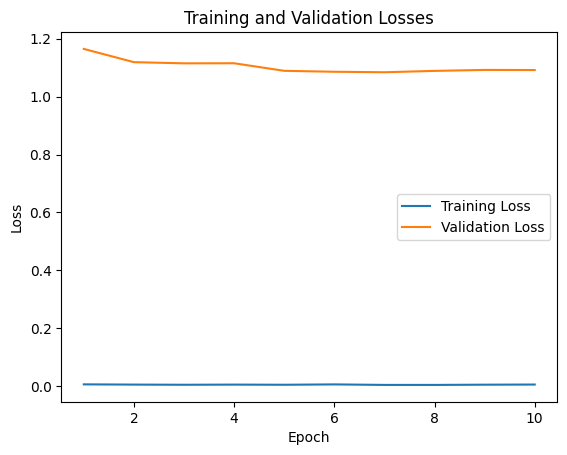

In [18]:
optimization_loop(model, 
                  train_loader, 
                  eval_loader, 
                  loss_fn, 
                  optimizer, 
                  device=device,
                  metric=metric, 
                  n_epochs=n_epochs, 
                  model_save_path=model_save_path) # Path to save the BEST model

# Model testing

Once the optimization is complete, you can test your model on the test data. This means that you apply your model to the images in your dataset. To do this, iterate over all instances in your test data set.

1. Initialize the best performing model.
2. Initialize the F1 score metric from TorchVision.
3. Iterate over all instances in the test dataset and update your metric after each batch.
4. Compute the final metric.

In [19]:
from torchmetrics import F1Score

model.load_state_dict(torch.load('best_model.pth'))

f1_score_metric = F1Score(task=task,num_classes=num_classes).to(device)

model.eval()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad(): 
        outputs = model(images)

    f1_score_metric(outputs, labels)

final_f1_score = f1_score_metric.compute()

print("Final F1 Score:", final_f1_score)

KeyboardInterrupt: 